# Central Bank Communication & Information Overload
**Goal**: Build a Communication Intensity Index (CII) from Fed speeches and study its (non-linear) impact on market volatility and reactions.

**Pipeline overview**
1. Descriptive exploration of speeches (Fed) & markets (VIX, SPX, TNX, DXY, EURUSD)
2. Lexical and Tonal Analysis
3. Communication Saturation Index (CSI)
4. Building the Communication Intensity Index (CII)
5. Market Reaction Analysis: Linking Communication to Market Dynamics


In [1]:
#!pip install yfinance --quiet

#### Step 1: Descriptive exploration of speeches

Goal: understand the structure and dynamics of the corpus.

→ Purpose: before doing any NLP, identify who speaks, when, how often, at what pace, and under what conditions.

Distribution of word count by year and by speaker,
Evolution of the number of speeches over time,
Correlation between length and frequency,
Number of active speakers per month

In [2]:
pip install -U sentence-transformers

^C
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Optional visuals
import seaborn as sns

# NLP helpers
import re, nltk
from nltk.corpus import stopwords
from collections import Counter

# Sklearn stuff
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Sentence embeddings
from sentence_transformers import SentenceTransformer

# NLTK data (run once)
nltk.download("stopwords")

# Load speeches 
speeches = pd.read_csv("fed_speeches.csv", parse_dates=["date"]).sort_values("date")

# Basic hygiene
speeches = speeches.drop_duplicates(subset=["url", "date", "speaker"])
speeches["word_count"] = pd.to_numeric(speeches.get("word_count"), errors="coerce")
speeches = speeches.dropna(subset=["text", "date", "speaker"])
speeches = speeches[speeches["text"].str.len() > 30]
speeches = speeches[speeches["word_count"] > 20].reset_index(drop=True)

# Time keys
speeches["year"]  = speeches["date"].dt.year
speeches["month"] = speeches["date"].dt.to_period("M").dt.to_timestamp("M")
speeches["week"]  = speeches["date"].dt.to_period("W-FRI").dt.to_timestamp("W-FRI")

c:\Users\alexn\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alexn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Yearly summary:
       n_speeches       avg_wc  n_speakers
year                                     
2021          68  2322.838235           8
2022          45  2188.088889           9
2023          95  2090.768421           8
2024         104  2498.903846           8
2025         100  2356.920000          12

Top speakers:
                                 n_speeches       avg_wc
speaker                                                
Governor Michelle W. Bowman            116  2503.068966
Governor Lael Brainard                  99  2710.101010
Governor Christopher J. Waller          70  2402.842857
Chair Jerome H. Powell                  61  1458.704918
Chairman Ben S. Bernanke                52  2703.192308
Governor Jerome H. Powell               50  2351.700000
Vice Chairman Stanley Fischer           45  2913.644444
Chair Janet L. Yellen                   44  2737.136364
Governor Lisa D. Cook                   42  2050.095238
Governor Daniel K. Tarullo              39  4497.051282


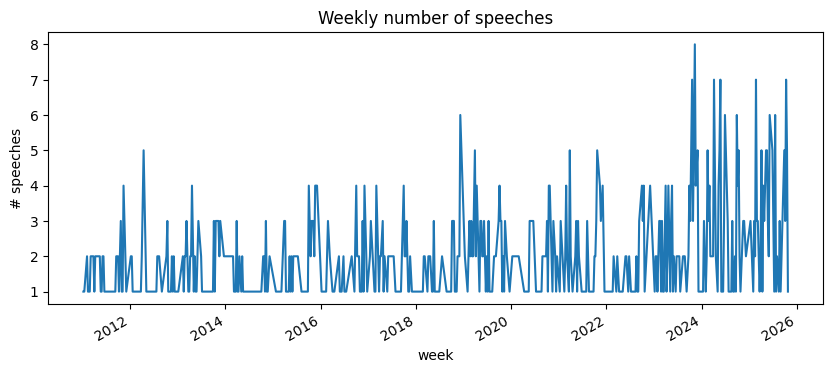

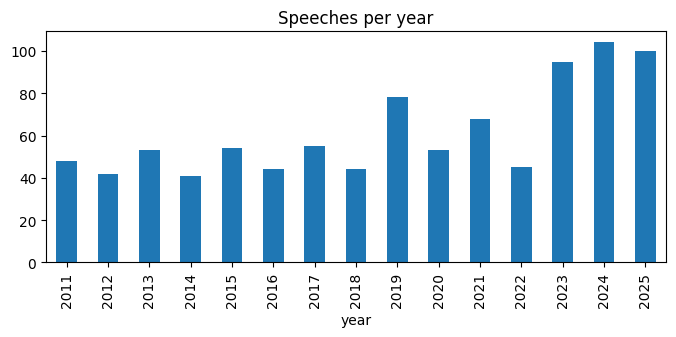


Correlation (# speeches vs avg length): -0.03


In [2]:
# Basic yearly and speaker stats
by_year = speeches.groupby("year").agg(
    n_speeches=("text", "count"),
    avg_wc=("word_count", "mean"),
    n_speakers=("speaker", "nunique")
)
by_speaker = speeches.groupby("speaker").agg(
    n_speeches=("text", "count"),
    avg_wc=("word_count", "mean")
).sort_values("n_speeches", ascending=False).head(10)

print("Yearly summary:\n", by_year.tail())
print("\nTop speakers:\n", by_speaker)

# Weekly and monthly cadence
weekly = speeches.groupby("week").agg(
    n_speeches=("text", "count"),
    avg_wc=("word_count", "mean"),
    n_speakers=("speaker", "nunique")
)

monthly = speeches.groupby("month").agg(
    n_speeches=("text", "count"),
    avg_wc=("word_count", "mean"),
    n_speakers=("speaker", "nunique")
)

# 3) Quick plots
weekly["n_speeches"].plot(figsize=(10,4), title="Weekly number of speeches", ylabel="# speeches")
plt.show()

by_year["n_speeches"].plot(kind="bar", figsize=(8,3), title="Speeches per year")
plt.show()

# 4) Correlation: are busy weeks longer on average?
corr = weekly["n_speeches"].corr(weekly["avg_wc"])
print(f"\nCorrelation (# speeches vs avg length): {corr:.2f}")

The correlation between the number of speeches per week and their average length is slightly negative (–0.03).
This indicates that when the Fed communicates more frequently, speeches are not necessarily longer and may even be slightly shorter.

#### Step 2: Lexical and Tonal Analysis

Goal: Extract the main lexical fields, tone, and semantic redundancies in Fed speeches.
This section cleans and tokenizes the texts, identifies the most frequent and discriminant words (via TF-IDF), and groups speeches into semantic clusters using sentence embeddings (SBERT) and K-Means/UMAP.

Finally, it analyzes the tone (FinBERT or VADER) across themes, speakers, and time periods — revealing which topics are more positive, negative, or neutral, and how the Fed’s communication focus shifts during market stress (e.g., inflation, policy stance, financial stability).

In [3]:
import pandas as pd, re, nltk
from nltk.corpus import stopwords
from collections import Counter
nltk.download('stopwords')

speeches = pd.read_csv("fed_speeches.csv", parse_dates=["date"]).sort_values("date")
speeches = speeches.dropna(subset=["text"]).copy()
speeches = speeches[speeches["text"].str.len() > 30].reset_index(drop=True)

STOPWORDS = set(stopwords.words("english"))                                     # Convert everything to lowercase (case-insensitive analysis)
def clean_text(txt):
    txt = str(txt).lower()
    txt = re.sub(r"[^a-z\s]", " ", txt)                                         # Remove punctuation, numbers, and symbols
    return [w for w in txt.split() if w not in STOPWORDS and len(w) > 2]        # Split text into individual words (“tokens”), remove useless common words (“the”, “and”, “of”…) and remove ultra-short tokens like “a”, “us”, “it”

speeches["tokens"] = speeches["text"].apply(clean_text)
speeches["year"] = speeches["date"].dt.year

# Top frequent words per year : here, we group all speeches from the same year, merge all their tokens and find the most common words 
def top_words_by_year(df, n=10):
    return (
        df.groupby("year")["tokens"]
          .apply(lambda x: Counter([w for tokens in x for w in tokens]).most_common(n))
    )

# Flatten yearly top words to a tidy DataFrame
records = []
top_words = top_words_by_year(speeches, n=15)
for year, lst in top_words.items():
    for word, count in lst:
        records.append((int(year), word, int(count)))

df_top = pd.DataFrame(records, columns=["year", "word", "count"]).sort_values(["year","count"], ascending=[True, False]) 

# Normalize by total tokens per year (so years are comparable)
year_totals = (
    speeches.groupby("year")["tokens"]
            .apply(lambda toks: sum(len(t) for t in toks))
            .rename("year_token_total")
)
df_top = df_top.merge(year_totals, on="year", how="left")
df_top["freq_pct"] = 100 * df_top["count"] / df_top["year_token_total"]

# Quick global word frequency: this merges all speeches together, giving the 30 most frequent words in the full dataset:
all_words = [w for tokens in speeches["tokens"] for w in tokens]
freq = Counter(all_words).most_common(30)
pd.DataFrame(freq, columns=["word", "count"]).head(10)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alexn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,word,count
0,financial,12594
1,policy,10922
2,inflation,10427
3,banks,9094
4,federal,8708
5,market,7501
6,rate,7162
7,bank,6802
8,percent,6617
9,reserve,6436


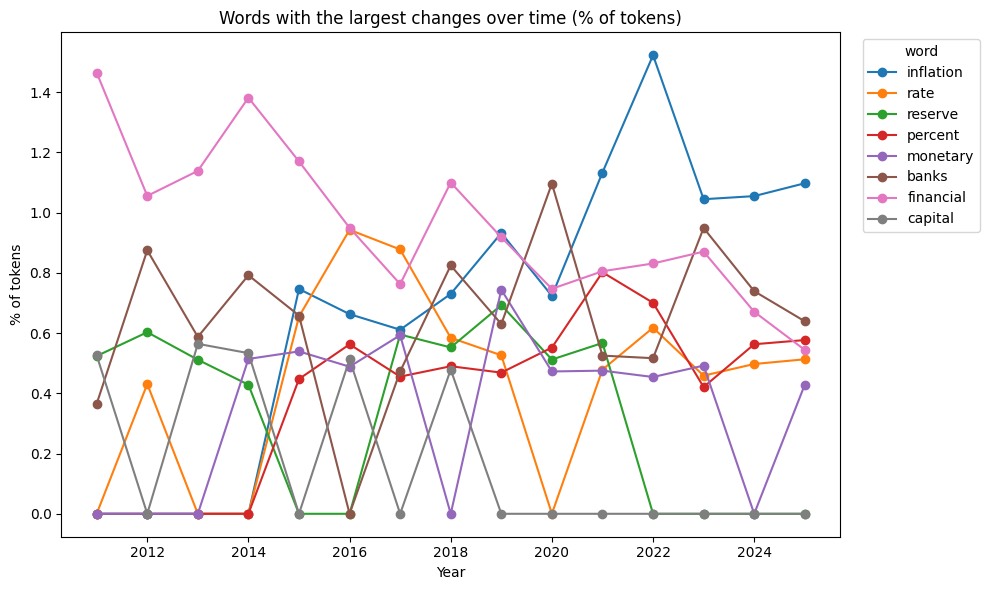

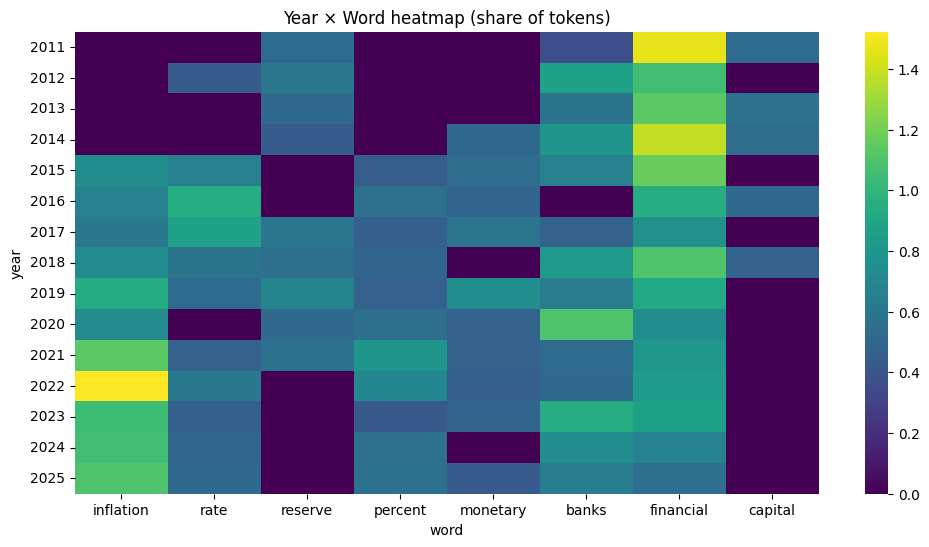

In [4]:
# Pivot to year x word matrix of % frequencies
mat = df_top.pivot_table(index="year", columns="word", values="freq_pct", fill_value=0)

# Pick words with largest variance over years
top_var_words = mat.var().sort_values(ascending=False).head(8).index.tolist()

mat[top_var_words].plot(figsize=(10,6), marker="o")
plt.title("Words with the largest changes over time (% of tokens)")
plt.xlabel("Year"); plt.ylabel("% of tokens"); plt.legend(title="word", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout(); plt.show()

# Heatmap
plt.figure(figsize=(12,6))
sns.heatmap(mat[top_var_words], cmap="viridis")
plt.title("Year × Word heatmap (share of tokens)")
plt.xlabel("word"); plt.ylabel("year")
plt.show()

Ce qu'on fais cellule ci-dessous c'est si par exemple on a : 
En 2020, la Fed publie 50 discours (dont 10 mentionnent “inflation”).
En 2023, elle publie 150 discours (dont 30 mentionnent “inflation”).
Si on compare juste les comptages bruts (10 → 30), on peut croire que “inflation” est 3× plus important en 2023.
Mais c’est simplement qu’il y a eu 3× plus de discours.
Donc ici, on corrige ce biais en divisant par le nombre total de mots publiés cette année-là.

In [6]:
if "year" not in speeches.columns:
    speeches["year"] = speeches["date"].dt.year

year_totals = (
    speeches.groupby("year")["tokens"]
             .apply(lambda toks: sum(len(t) for t in toks))
             .rename("year_token_total")
)
speeches = speeches.merge(year_totals, on="year", how="left")

speeches["token_count"] = speeches["tokens"].apply(len)

# Per-year token totals (for normalization)
year_totals = (
    speeches.groupby("year")["tokens"]
            .apply(lambda toks: sum(len(t) for t in toks))
            .rename("year_token_total")
)

df_top = df_top.merge(year_totals, on="year", how="left")
df_top["freq_pct"] = 100 * df_top["count"] / df_top["year_token_total"]
df_top

,year,word,count,year_token_total_x,freq_pct,year_token_total_y,year_token_total
0,2011,financial,1275,87036,1.464911,87036,87036
1,2011,federal,577,87036,0.662944,87036,87036
2,2011,economic,517,87036,0.594007,87036,87036
3,2011,market,485,87036,0.557241,87036,87036
4,2011,policy,471,87036,0.541155,87036,87036
...,...,...,...,...,...,...,...
220,2025,also,645,131558,0.490278,131558,131558
221,2025,bank,632,131558,0.480396,131558,131558
222,2025,would,608,131558,0.462154,131558,131558
223,2025,federal,583,131558,0.443151,131558,131558


##### EXPLICATION CODE PRECEDANT 

Il lit notre fichier fed_speeches.csv contenant tous les discours (date, speaker, texte, word_count…).

Il nettoie le texte : met tout en minuscules, supprime la ponctuation, les chiffres et les mots vides (“the”, “and”, “of”…), garde uniquement les mots de plus de 2 lettres.
Il crée une nouvelle colonne tokens contenant les mots utiles pour chaque discours.

Il ajoute une colonne year pour faciliter les regroupements par année.

Ensuite la fonction top_words_by_year : pour chaque année, on tous les discours et compte les mots les plus fréquents.
→ On peut voir l’évolution du vocabulaire : par exemple “inflation” dominait en 2018-19, “pandemic” en 2020, “policy” ou “rates” ensuite.

Top words : comptage sur l’ensemble des années pour connaître le vocabulaire central de la Fed.

But : repérer les grandes tendances lexicales avant toute modélisation pour voir apparaître les thématiques principales et leur évolution temporelle.

2.1 TF-IDF — Top discriminative terms (by year / by speaker)

What it does: build a TF-IDF matrix on cleaned speeches, then for each group (year or speaker), average TF-IDF scores and list the top terms.

In [7]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

speeches = speeches.copy()
speeches["year"] = speeches["date"].dt.year

# Build TF-IDF (1-2 grams, light pruning)
vectorizer = TfidfVectorizer(
    lowercase=True, stop_words="english",
    ngram_range=(1,2), min_df=5, max_df=0.9
)
X = vectorizer.fit_transform(speeches["text"].fillna(""))
terms = np.array(vectorizer.get_feature_names_out())

def top_tfidf_for_groups(group_col, topk=15, min_group_size=5):
    out = {}
    for g, idx in speeches.groupby(group_col).indices.items():
        if len(idx) < min_group_size: 
            continue
        avg = np.asarray(X[idx].mean(axis=0)).ravel()
        top_idx = np.argsort(avg)[::-1][:topk]
        out[g] = list(zip(terms[top_idx], avg[top_idx]))
    return out

top_by_year = top_tfidf_for_groups("year", topk=15, min_group_size=5)
top_by_speaker = top_tfidf_for_groups("speaker", topk=15, min_group_size=5)

for year, words in sorted(top_by_year.items()):
    print(f"\n{year}")
    print(", ".join([w for w, _ in words]))


2011
financial, capital, economic, policy, crisis, term, market, recovery, fiscal, federal reserve, firms, credit, rates, economies, monetary

2012
banks, financial, community, mortgage, policy, term, market, federal reserve, housing, community banks, recovery, economic, lending, banking, crisis

2013
financial, capital, policy, banks, market, term, crisis, federal reserve, risk, bank, asset, community, monetary, economic, rate

2014
financial, policy, banks, community, risk, monetary, capital, crisis, market, monetary policy, firms, community banks, bank, federal reserve, rate

2015
financial, inflation, policy, market, rate, banks, monetary, crisis, liquidity, monetary policy, capital, institutions, community, percent, markets

2016
rate, inflation, financial, growth, policy, percent, productivity, market, monetary, labor, monetary policy, rates, economic, capital, economy

2017
policy, rate, inflation, financial, monetary, monetary policy, rates, market, banks, economic, federal re

In [8]:
for spk, words in list(top_by_speaker.items())[:5]:
    print(f"\n{spk}")
    print(", ".join([w for w, _ in words]))


Chair Janet L. Yellen
inflation, rate, policy, financial, labor, economic, monetary, monetary policy, economy, percent, funds rate, fomc, market, community, women

Chair Jerome H. Powell
inflation, policy, percent, economy, monetary, labor, monetary policy, economic, pandemic, fed, market, growth, labor market, rate, time

Chairman Ben S. Bernanke
financial, economic, federal reserve, banks, policy, term, community, crisis, monetary, fiscal, market, recovery, rates, economy, capital

Chairman Jerome H. Powell
inflation, financial, unemployment, policy, economy, rural, rate, monetary, labor, communities, monetary policy, fed, community, growth, crisis

Governor Adriana D. Kugler
inflation, labor, phillips, phillips curve, pandemic, percent, curve, curve model, kugler, supply, policy, workers, goods, inflation dynamics, prices


##### EXPLICATION CODE PRECEDANT 

On transforme tous les textes en une matrice TF-IDF (Term Frequency – Inverse Document Frequency).
Cette méthode donne plus de poids aux mots typiques d’un texte, et moins à ceux qu’on retrouve partout.
On obtient une matrice X où chaque ligne = un discours, chaque colonne = un mot et chaque cellule = importance du mot dans ce discours.

Ensuite on calcule la moyenne des scores TF-IDF par année et par orateur et extrait les top 15 mots les plus représentatifs de chacun.

Exemples de lecture :
En 2020, les mots TF-IDF les plus discriminants pourraient être “pandemic”, “support”, “recovery”.
Pour Jerome Powell, on pourrait retrouver “policy”, “rate”, “inflation”.
Pour Lael Brainard, davantage “climate”, “inclusion”, “digital”.

But : identifier les mots qui définissent le style ou la période d’un discours, pas seulement les plus fréquents.

#### 2.3 Semantic themes — Embeddings + K-Means (and optional UMAP coords)

What it does: create sentence embeddings for each speech, cluster them into themes, label each speech with a cluster, and compute top TF-IDF terms per cluster to interpret themes.

In [9]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

texts = speeches["text"].fillna("").tolist()

# rebuild TF-IDF if needed
if "X" not in locals() or "terms" not in locals():
    vectorizer = TfidfVectorizer(lowercase=True, stop_words="english",
                                 ngram_range=(1,2), min_df=5, max_df=0.9)
    X = vectorizer.fit_transform(texts)
    terms = np.array(vectorizer.get_feature_names_out())

model = SentenceTransformer("all-MiniLM-L6-v2")
emb = model.encode(texts, show_progress_bar=True, convert_to_numpy=True)

K = 6
km = KMeans(n_clusters=K, n_init=10, random_state=42)
speeches["theme_cluster"] = km.fit_predict(emb)

def top_terms_for_cluster(cluster_id, topk=20):
    idx = speeches.index[speeches["theme_cluster"] == cluster_id].tolist()
    if not idx: return []
    avg = np.asarray(X[idx].mean(axis=0)).ravel()
    top_idx = np.argsort(avg)[::-1][:topk]
    return list(zip(terms[top_idx], avg[top_idx]))

cluster_terms = {c: top_terms_for_cluster(c, topk=20) for c in range(K)}
cluster_terms

# optional UMAP coords
try:
    import umap
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric="cosine", random_state=42)
    coords_2d = reducer.fit_transform(emb)
    speeches["umap_x"] = coords_2d[:,0]
    speeches["umap_y"] = coords_2d[:,1]
except Exception:
    pass

Batches: 100%|██████████| 30/30 [01:06<00:00,  2.20s/it]


##### EXPLICATION CODE PRECEDANT 

On utilise le modèle SentenceTransformer (“all-MiniLM-L6-v2”) pour convertir chaque discours en un vecteur numérique (embedding) qui capture son sens global (même si les mots diffèrent).
Ensuite, un K-Means regroupe les discours similaires en K = 6 thèmes principaux (par ex. : Inflation / Employment / Financial Stability / Policy Rates / Balance Sheet / International).
Pour chaque cluster, le code calcule les mots TF-IDF dominants, ce qui aide à interpréter les thèmes.
En option, il calcule des coordonnées UMAP (x, y) pour une visualisation 2D, où chaque point = un discours coloré par thème.
Résultat attendu :
Un DataFrame speeches enrichi avec une colonne theme_cluster.
Un dictionnaire cluster_terms listant les 20 mots les plus représentatifs de chaque thème.

But : passer d’une vision “par date” à une vision par contenu.
On sait maintenant quels types de discours la Fed répète, quels sujets dominent, et comment ils se structurent sémantiquement.

In [10]:
import matplotlib.pyplot as plt

if {"umap_x","umap_y","theme_cluster"}.issubset(speeches.columns):
    plt.figure(figsize=(8,6))
    for c in sorted(speeches["theme_cluster"].unique()):
        m = speeches["theme_cluster"] == c
        plt.scatter(speeches.loc[m, "umap_x"], speeches.loc[m, "umap_y"], s=10, alpha=0.6, label=f"Cluster {c}")
    plt.title("Semantic map of speeches (UMAP)"); plt.legend(markerscale=2, bbox_to_anchor=(1.02,1), loc="upper left"); plt.tight_layout(); plt.show()

Explication : 

Chaque point = un discours individuel.
Les coordonnées umap_x, umap_y ne veulent rien dire en soi, c'est juste des coordonnées compressées en 2D (réduction de dimensionnalité par UMAP)
→ le but est que les discours sémantiquement proches (mêmes thèmes, mêmes mots-clés) soient rapprochés visuellement.

Chaque couleur correspond à un cluster thématique obtenu par KMeans sur les embeddings du texte.
Donc :
Points de la même couleur → discours qui parlent d’à peu près les mêmes sujets 
Points éloignés ou d’une autre couleur → discours différents dans leur champ lexical.
Mais pour savoir ce que chaque cluster signifie, il faut lire les mots dominants de chacun.
--> C’est ce que renvoie ton dictionnaire cluster_terms

In [11]:
for c in sorted(cluster_terms.keys()):
    kw = ", ".join([w for w,_ in cluster_terms[c][:12]])
    print(f"Cluster {c}: {kw}")

Cluster 0: community, banks, community banks, communities, bank, cra, banking, financial, community development, federal reserve, regulatory, small
Cluster 1: inflation, policy, monetary, rate, monetary policy, fomc, percent, market, labor, economic, economy, rates
Cluster 2: economics, women, economic, inflation, students, education, life, economy, financial, labor, pandemic, percent
Cluster 3: inflation, percent, policy, labor, rate, growth, market, monetary, economy, economic, monetary policy, year
Cluster 4: financial, capital, banks, stress, risk, firms, banking, liquidity, regulatory, bank, crisis, requirements
Cluster 5: payments, payment, financial, ai, cbdc, innovation, banks, digital, technology, crypto, stablecoins, bank


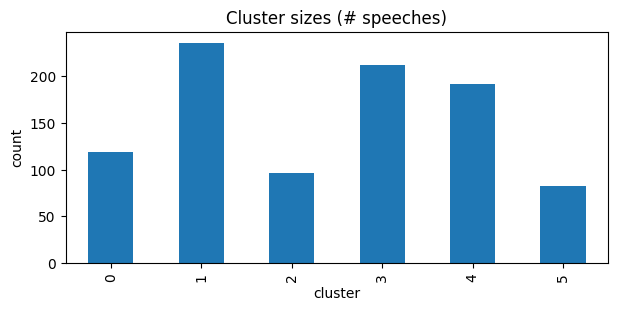

In [12]:
counts = speeches["theme_cluster"].value_counts().sort_index()
counts.plot(kind="bar", figsize=(7,3), title="Cluster sizes (# speeches)"); plt.xlabel("cluster"); plt.ylabel("count"); plt.show()

Explication : 

Represente la taille de chaque cluster, donc combien de discours sont associés à chaque thème.

Interprétation :
Un cluster très gros (ex. 1 ou 3) = un sujet central dans les communications de la Fed (typiquement « inflation/policy »).
Un petit cluster (ex. 5) = thème de niche ou période courte (ex. « crypto », « CBDC », « inclusion »).
Si un cluster est surreprésenté, il faudra voir si c’est lié à un contexte macro (crise, pandémie, réforme).

Conclusion: la Fed parle surtout de 2–3 grands axes récurrents, les autres sont des sujets spécifiques.

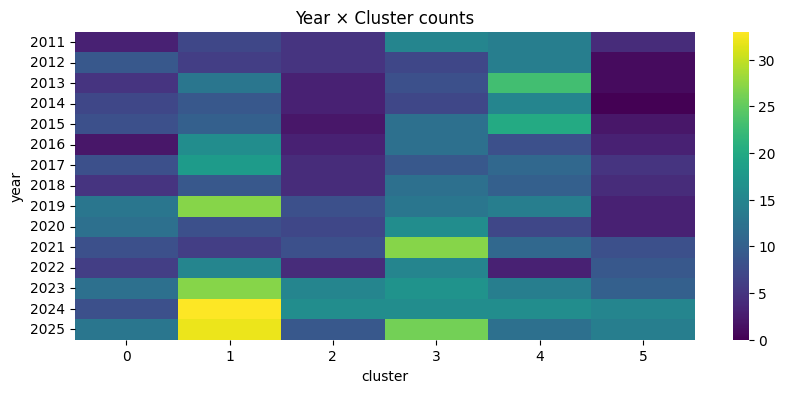

In [13]:
import pandas as pd
import seaborn as sns

speeches["year"] = speeches["date"].dt.year
tab = pd.crosstab(speeches["year"], speeches["theme_cluster"])
plt.figure(figsize=(10,4)); sns.heatmap(tab, cmap="viridis"); plt.title("Year × Cluster counts"); plt.xlabel("cluster"); plt.ylabel("year"); plt.show()

Explication : 

Represente comment la présence de chaque thème évolue dans le temps (2011–2025).
Plus la couleur est claire = plus de discours de ce type cette année-là.

#### 2.4 FinBERT Tone Scoring & Temporal Trends (by year, speaker, and theme)
Ajouter les scores FinBERT (positif / négatif / neutre) et visualiser l’évolution du ton par période, par thème, ou par orateur.
Utiliser FinBERT, un modèle de langage entraîné spécifiquement pour la finance. Il apprend à reconnaître le sentiment du marché exprimé dans un texte.
Les trois classes mesurent le ton perçu du point de vue d’un investisseur, pas d’un journaliste ou d’un citoyen.
- positive : ton confiant, rassurant ou optimiste sur l’économie, la croissance, la politique monétaire ou la stabilité financière. Le texte suggère des conditions favorables.
- neutral : ton informatif, descriptif ou factuel, sans jugement de valeur ni émotion apparente. Comme on le voit ci-dessous, c’est souvent le cas des discours de la Fed.
- negative : ton inquiet, prudent ou pessimiste, signalant des risques ou des difficultés économiques.

In [29]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline

finbert = pipeline("sentiment-analysis",
                   model="yiyanghkust/finbert-tone",
                   tokenizer="yiyanghkust/finbert-tone")

# Example: sentiment of a text by adding a sentence just to test what it returns 
finbert("Inflation pressures remain elevated while growth slows.")

Device set to use cpu


[{'label': 'Negative', 'score': 0.9999305009841919}]

Initialisation du pipeline FinBERT...


Device set to use cpu


Début de l'analyse de sentiment (cela peut prendre du temps)...
Analyse de sentiment terminée.

DataFrame enrichi sauvegardé avec succès dans 'speeches_with_nlp.csv'.

Aperçu des nouvelles colonnes :


,date,speaker,sentiment,tone_score
0,2011-01-07,Governor Elizabeth A. Duke,Neutral,0
1,2011-01-08,Vice Chair Janet L. Yellen,Neutral,0
2,2011-02-02,Governor Elizabeth A. Duke,Neutral,0
3,2011-02-03,Chairman Ben S. Bernanke,Neutral,0
4,2011-02-11,Governor Sarah Bloom Raskin,Positive,1


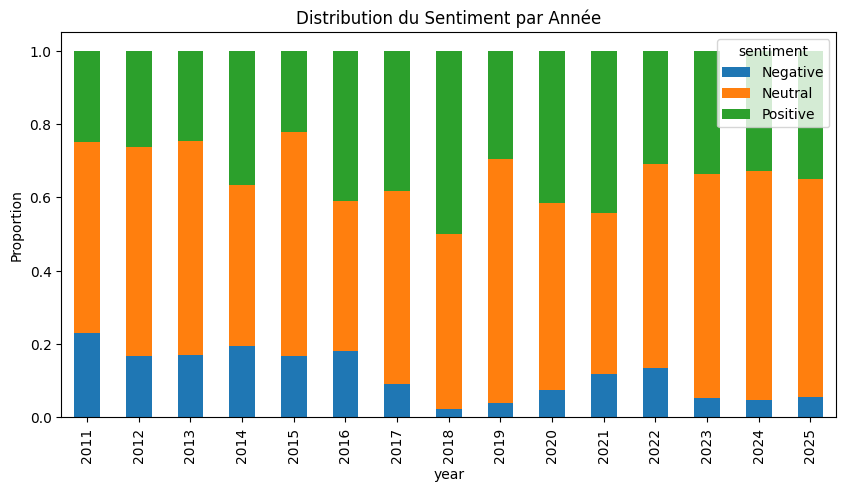

In [66]:
try:
    finbert_pipeline
except NameError:
    print("Initialisation du pipeline FinBERT...")
    finbert_pipeline = pipeline("sentiment-analysis",
                                model="yiyanghkust/finbert-tone",
                                tokenizer="yiyanghkust/finbert-tone")

print("Début de l'analyse de sentiment (cela peut prendre du temps)...")
if not speeches.empty:
    speeches["sentiment"] = speeches["text"].apply(lambda x: finbert_pipeline(x[:512])[0]['label'])
    print("Analyse de sentiment terminée.")

    sentiment_mapping = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
    speeches['tone_score'] = speeches['sentiment'].map(sentiment_mapping)
    
    output_filename = "speeches_with_nlp.csv"
    speeches.to_csv(output_filename, index=False, encoding='utf-8')

    print(f"\nDataFrame enrichi sauvegardé avec succès dans '{output_filename}'.")
    print("\nAperçu des nouvelles colonnes :")
    display(speeches[['date', 'speaker', 'sentiment', 'tone_score']].head())

    sentiment_by_year = pd.crosstab(speeches["year"], speeches["sentiment"], normalize="index")
    sentiment_by_year.plot(kind="bar", stacked=True, figsize=(10, 5), title="Distribution du Sentiment par Année")
    plt.ylabel("Proportion")
    plt.show()
else:
    print("Le DataFrame 'speeches' est vide. Veuillez exécuter les cellules de chargement de données au préalable.")

#### 2.5 Influential Words and Market Sensitivity

A FAIRE

Les discours de la Fed restent majoritairement neutres, avec des fluctuations du ton positif selon le contexte économique. 
Le ton devient plus “cautious” (mesuré) après 2022, probablement en lien avec la lutte contre l’inflation et la crainte d’un ralentissement.

#### Part 3: Communication Saturation Index (CSI)

Objective: quantify the degree of repetition in Federal Reserve communication over time.

We construct two complementary measures of message similarity based on text embeddings:
- (A) Within-week redundancy: captures how similar speeches are to one another within the same week — a proxy for short-term coordination or duplication of messages.
- (B) Short-horizon repetition: measures how similar each new speech is to recent past communications (typically within the last 8 weeks), reflecting the persistence or re-use of prior narratives.

Required inputs:
- speeches DataFrame containing date (datetime), text (str), and week (week ending Friday), optional theme_cluster or speaker.
- emb (SBERT embeddings) — a NumPy array of shape [n_docs, d].
If emb is not already in memory, it is computed using SentenceTransformer("all-MiniLM-L6-v2").

Output:
- A weekly panel combining both metrics: Within-week redundancy: average cosine similarity among speeches of the same week.
- Max-to-past (L = 8 weeks): for each speech, cosine similarity with its most similar speech over the previous 8 weeks, then averaged by week.

,csi_within_mean,csi_recent_maxavg,n_speeches
week,,,
2017-07-14,1.000000,0.554830,2
2025-04-11,1.000000,0.492199,7
2017-02-24,NaN,0.936256,1
2015-02-06,NaN,0.905844,1
2024-08-16,NaN,0.892389,1
2016-11-04,NaN,0.855469,1
2024-05-03,NaN,0.838880,1
2021-05-14,0.699368,0.833725,3
2025-08-01,0.729393,0.831901,2


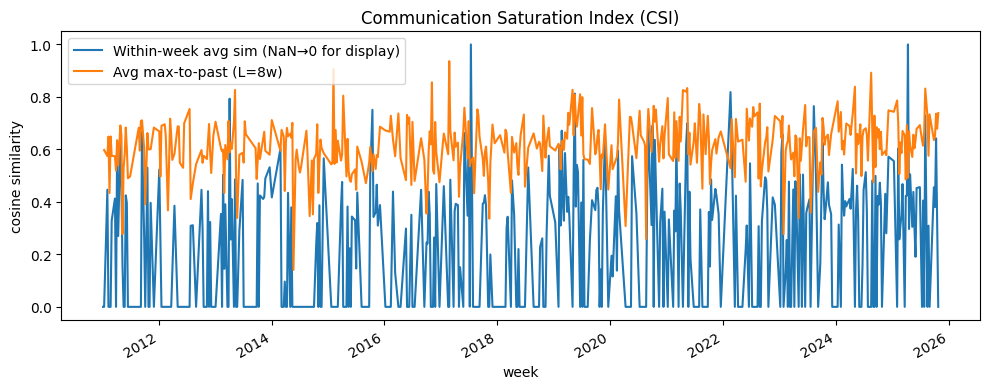

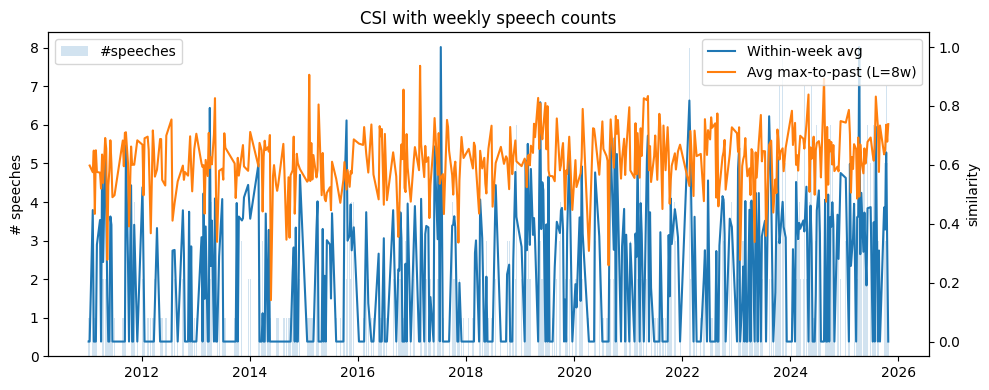

In [10]:
import numpy as np
import pandas as pd

# Preconditions 
assert "date" in speeches.columns and "text" in speeches.columns, "speeches must have 'date' and 'text'."
speeches = speeches.sort_values("date").reset_index(drop=True)
speeches["week"] = speeches["date"].dt.to_period("W-FRI").dt.to_timestamp("W-FRI")

# Reuse embeddings from Part 2 if present; otherwise compute once
try:
    emb  # already in memory from Part 2
except NameError:
    from sentence_transformers import SentenceTransformer
    model = SentenceTransformer("all-MiniLM-L6-v2")
    emb = model.encode(speeches["text"].fillna("").tolist(),
                       show_progress_bar=True, convert_to_numpy=True)

# Cosine similarity matrix 
emb = np.asarray(emb, dtype=float)
emb_norm = emb / np.clip(np.linalg.norm(emb, axis=1, keepdims=True), 1e-12, None)
S = (emb_norm @ emb_norm.T).astype(np.float32)
np.fill_diagonal(S, np.nan)  # ignore self-similarity

# CSI(A): within-week redundancy 
from itertools import combinations
TAU = 0.75  # near-duplicate threshold (tune if needed)

rows = []
for w, g in speeches.groupby("week", sort=True):
    idx = g.index.to_list()
    n = len(idx)
    if n < 2:
        # keep NaN in the table (truthful: not computable), but we will fill for plotting
        rows.append({"week": w, "csi_within_mean": np.nan, "csi_within_share_tau": np.nan, "n_speeches": n})
        continue
    sims = np.array([S[i, j] for i, j in combinations(idx, 2)], dtype=float)
    rows.append({
        "week": w,
        "csi_within_mean": float(np.nanmean(sims)),
        "csi_within_share_tau": float(np.mean(sims >= TAU)),
        "n_speeches": n
    })

csi_within = pd.DataFrame(rows).set_index("week").sort_index()

# CSI(B): repetition vs recent past (lookback L=8 weeks) 
L = 8  # lookback window in weeks (4–12 is typical)
week_code = pd.Categorical(speeches["week"]).codes
max_sim_past = np.full(len(speeches), np.nan, dtype=float)

for i in range(len(speeches)):
    wi = week_code[i]
    past_idx = speeches.index[(week_code < wi) & (week_code >= wi - L)]
    if len(past_idx):
        sims = S[i, past_idx]
        max_sim_past[i] = np.nanmax(sims) if np.isfinite(sims).any() else np.nan

speeches["max_sim_past"] = max_sim_past
csi_recent = (
    speeches.groupby("week")["max_sim_past"]
            .mean()
            .to_frame("csi_recent_maxavg")
            .sort_index()
)

# Final weekly CSI panel 
csi_panel = (
    csi_within
    .join(csi_recent, how="outer")
    .sort_index()
)

# A clean view for plotting (no NaNs): fill weeks with <2 speeches with 0 for the within-week line only
csi_plot = csi_panel.copy()
csi_plot["csi_within_mean_filled"] = csi_plot["csi_within_mean"].fillna(0.0)

# Minimal, useful outputs
# (a) Top-10 weeks by saturation (either metric)
rank = (
    csi_panel.assign(
        csi_rank_proxy = csi_panel[["csi_within_mean","csi_recent_maxavg"]].max(axis=1, skipna=True)
    )
    .sort_values("csi_rank_proxy", ascending=False)
    .head(10)[["csi_within_mean","csi_recent_maxavg","n_speeches"]]
)
display(rank)

# (b) Quick lines + counts
import matplotlib.pyplot as plt

ax = csi_plot[["csi_within_mean_filled","csi_recent_maxavg"]].plot(
    figsize=(10,4), ylabel="cosine similarity",
    title="Communication Saturation Index (CSI)"
)
ax.legend(["Within-week avg sim (NaN→0 for display)","Avg max-to-past (L=8w)"])
plt.tight_layout(); plt.show()

# bars for weekly #speeches + lines
fig, ax1 = plt.subplots(figsize=(10,4))
ax1.bar(csi_panel.index, csi_panel["n_speeches"].fillna(0), width=6, alpha=0.2, label="#speeches")
ax2 = ax1.twinx()
ax2.plot(csi_plot.index, csi_plot["csi_within_mean_filled"], label="Within-week avg", lw=1.5)
ax2.plot(csi_plot.index, csi_plot["csi_recent_maxavg"], label="Avg max-to-past (L=8w)", lw=1.5)
ax1.set_title("CSI with weekly speech counts")
ax1.set_ylabel("# speeches"); ax2.set_ylabel("similarity")
ax1.legend(loc="upper left"); ax2.legend(loc="upper right")
plt.tight_layout(); plt.show()

# (c) Save for Part 4 (CII)
csi_panel.to_csv("csi_weekly.csv")

Comment lire les deux CSI
Within-week avg similarity : redondance intra-semaine (si plusieurs discours sortent la même semaine et se ressemblent fortement, l’indice monte).
Avg max-to-past (L=8w) : degré de répétition par rapport aux 8 dernières semaines (si les nouveaux discours répètent trop le passé récent, l’indice monte).
Ces deux mesures capturent deux facettes de la saturation :
la surcharge immédiate (plusieurs speechs qui disent la même chose la même semaine),
la redite cumulative (répétition du même message sur quelques semaines).

TABLEAU : 
Le tableau présente les semaines avec les valeurs les plus élevées de similarité, selon les deux mesures :
- csi_within_mean : similarité moyenne entre les discours d’une même semaine ;
- csi_recent_maxavg : similarité moyenne avec les discours des 8 semaines précédentes.
On observe par exemple :
Des semaines avec csi_within_mean = 1.0, ce qui signifie que plusieurs discours de la même semaine étaient quasi identiques, probablement autour d’un même message-clé ou d’un événement majeur (comme une décision de politique monétaire ou un changement de taux).
Des valeurs élevées de csi_recent_maxavg (> 0.8) même quand il n’y a qu’un seul discours (n = 1). Cela traduit un fort recyclage de langage : le message actuel reprend très fidèlement les éléments de discours récents.
Ces pics suggèrent une communication centralisée et cohérente, souvent volontaire dans les périodes de crise ou de forte incertitude, lorsque la Fed souhaite marteler un message précis.

1er GRAPHE : 
Ce graphique superpose deux lignes :
En bleu : la similarité intra-semaine (within-week avg sim) — lorsque plusieurs responsables s’expriment sur la même période.
En orange : la similarité avec le passé proche (max-to-past, L=8w) — donc la réutilisation de messages récents.
Interprétation :
La courbe orange est globalement élevée et stable autour de 0.6 à 0.7, indiquant une forte continuité du discours dans le temps.
→ La Fed conserve une ligne narrative homogène sur plusieurs semaines : mêmes mots, mêmes thèmes (inflation, taux, politique monétaire).
La courbe bleue est plus volatile : elle dépend du nombre de discours chaque semaine.
→ Lorsqu’il y a plusieurs prises de parole simultanées (réunions FOMC, discours de plusieurs gouverneurs), la similarité augmente nettement, signe d’une coordination du message.
→ Les creux bleus correspondent souvent à des semaines avec un ou deux discours isolés, donc une mesure non pertinente (valeurs proches de 0 après remplissage NaN → 0).
En résumé, le niveau structurellement élevé du CSI (autour de 0.6) reflète un discours institutionnel très standardisé, avec des formulations répétées d’un mois à l’autre.

2nd GRAPHE : 

Ce graphe reprend les mêmes deux courbes (orange et bleue), mais y ajoute en fond les barres de volume de discours par semaine.
Interprétation :
On observe une corrélation visuelle entre le nombre de discours et la similarité intra-semaine :
lorsque la Fed multiplie les interventions (barres hautes), la courbe bleue a tendance à grimper.
→ Cela signifie que les semaines les plus bavardes sont aussi les plus répétitives : les intervenants tiennent des propos très proches.
La courbe orange reste, elle, relativement indépendante du nombre de discours :
→ même lorsqu’il y a peu de prises de parole, le contenu reste aligné sur les messages passés, confirmant la continuité stratégique de la communication.

Conclusion : 

Le Communication Saturation Index (CSI) met en évidence la forte homogénéité du discours de la Réserve fédérale américaine au fil du temps.
La similarité intra-semaine (bleue) traduit la coordination ponctuelle du message entre les différents membres du Board, tandis que la similarité avec le passé (orange) révèle une constance du narratif institutionnel, même sur des horizons de plusieurs semaines.
Cette redondance n’est pas nécessairement négative : elle renforce la prévisibilité et la crédibilité de la politique monétaire. Toutefois, une communication trop saturée pourrait à terme réduire l’attention ou la réactivité des marchés, préparant le terrain pour la mesure de l’intensité communicationnelle (CII) développée dans la partie suivante.

#### Part 4: Building the Communication Intensity Index (CII)

**Goal:** aggregate all Fed communication metrics into a single synthetic indicator reflecting the *intensity and potential market impact* of public statements.

We combine:
- **Quantitative dimension**: number of speeches, average word count, number of speakers.  
- **Tonal dimension**: average tone score (FinBERT: positive – negative).  
- **Redundancy dimension**: within-week & recent Communication Saturation Index (CSI).  

Each variable is standardized (z-score) and combined using equal weights or PCA-based weighting.  
The resulting weekly **CII** measures the *information pressure* emitted by the Fed, ready to be linked with market reactions in Part 5.


In [ ]:
import pandas as pd
import numpy as np

# Load or rebuild minimal inputs for the CII 

# Communication metrics (panel_weekly)

speeches["week"] = speeches["date"].dt.to_period("W-FRI").dt.to_timestamp("W-FRI")
panel_weekly = (
    speeches.groupby("week")
            .agg(n_speeches=("text","count"),
                 sum_wordcount=("word_count","sum"),
                 mean_wordcount=("word_count","mean"),
                 n_speakers=("speaker", lambda s: s.nunique()))
            .sort_index()
)

# Tone metrics (nlp_weekly)
try:
    nlp_weekly = pd.read_csv("speeches_with_nlp.csv", parse_dates=["date"])
    nlp_weekly["week"] = nlp_weekly["date"].dt.to_period("W-FRI").dt.to_timestamp("W-FRI")
    nlp_weekly = (
        nlp_weekly.groupby("week")
                  .agg(tone_score_w=("tone_score", "mean"))
                  .sort_index()
    )
except Exception:
    print("Tone file not found; tone_score_w will be NaN")
    nlp_weekly = pd.DataFrame(columns=["tone_score_w"])

# Redundancy metrics (csi_panel)
try:
    csi_panel = pd.read_csv("csi_weekly.csv", parse_dates=["week"]).set_index("week")
except Exception:
    print("CSI file not found; you can rerun Part 3 if needed")
    csi_panel = pd.DataFrame(columns=["csi_within_mean","csi_recent_maxavg"])

Explained variance (1st component): 0.495


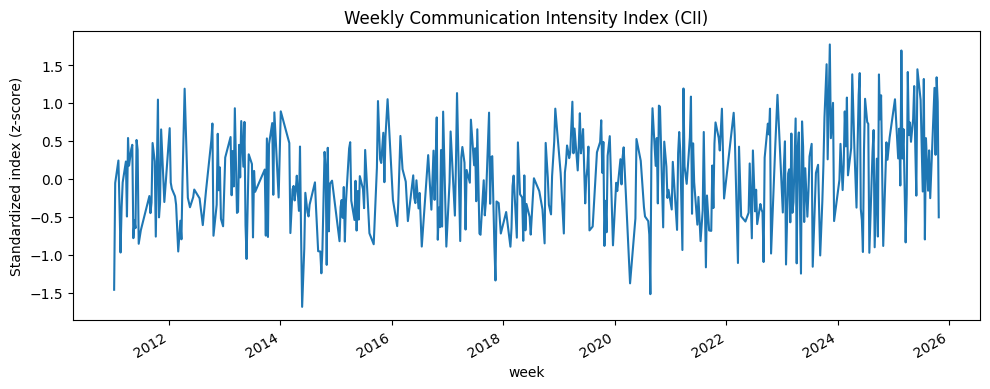

In [68]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Prérequis : réutilisation des panels précédents ---
# panel_weekly : métriques de communication (n_speeches, mean_wordcount, etc.)
# nlp_weekly   : tone scores (sent_pos_w, sent_neg_w, tone_score_w)
# csi_panel    : indices de redondance (csi_within_mean, csi_recent_maxavg)

# Fusion propre
cii_base = (
    panel_weekly
    .join(nlp_weekly[["tone_score_w"]], how="left")
    .join(csi_panel[["csi_within_mean","csi_recent_maxavg"]], how="left")
    .fillna(0)
)

# Sélection des composantes du CII ---
features = [
    "n_speeches", "mean_wordcount", "n_speakers",      # Quantitatif
    "csi_within_mean", "csi_recent_maxavg"            # Redondance
]

cii = cii_base[features].copy()

# Standardisation (z-scores) ---
scaler = StandardScaler()
cii_z = pd.DataFrame(
    scaler.fit_transform(cii),
    index=cii.index,
    columns=[f"{c}_z" for c in cii.columns]
)

# Agrégation simple (CII global) ---
cii_z["CII"] = cii_z.mean(axis=1)

# Option : pondération par PCA (plus robuste)
try:
    from sklearn.decomposition import PCA
    pca = PCA(n_components=1)
    cii_z["CII_pca"] = pca.fit_transform(cii_z[cii_z.columns[:-1]])
    print("Explained variance (1st component):", round(pca.explained_variance_ratio_[0],3))
except Exception as e:
    print("PCA not available, fallback to simple mean:", e)

# Visualisation
plt.figure(figsize=(10,4))
cii_z["CII"].plot(title="Weekly Communication Intensity Index (CII)")
plt.ylabel("Standardized index (z-score)")
plt.tight_layout()
plt.show()

# Export pour Partie 5 
cii_z.to_csv("cii_weekly.csv")

### How it works

1. **Quantitative signals**
   - `n_speeches`: more speeches → more communication pressure  
   - `mean_wordcount`: longer speeches → higher informational density  
   - `n_speakers`: reflects diversity of voices (potentially more noise)

2. **Tonal signal**
   - `tone_score_w = sent_pos_w – sent_neg_w`  
   Extreme values (positive or negative) indicate strong communication tone.

3. **Redundancy signals (from CSI)**
   - `csi_within_mean`: how similar speeches are within a week  
   - `csi_recent_maxavg`: how similar they are to recent weeks  
   High values → repetitive, potentially less informative communication.

4. **Normalization**
   Each variable is converted into a z-score:  
   \[
   z_i = \frac{x_i - \bar{x}}{\sigma_x}
   \]
   to make them comparable across different scales.

5. **Aggregation**
   The CII is the *mean of all standardized metrics*, optionally refined by PCA weighting.

6. **Interpretation**
   - **High CII** → intense, repetitive, and tonally strong communication → high potential market attention.  
   - **Low CII** → calmer communication periods, fewer or neutral speeches.

This weekly index will be merged with market data in **Part 5**  
to test whether higher CII predicts stronger movements in SPX, VIX, or yields.


#### Part 5: Market Reaction Analysis: Linking Communication to Market Dynamics

Objective:
The goal of this section is to examine how Federal Reserve communication affects financial markets in the short term.  
Specifically, we test whether fluctuations in the **Communication Intensity Index (CII)**, **tone**, or **redundancy (CSI)** are associated with significant market reactions in the days following speeches.

Core idea:
Each Fed speech—or each week of communication—can trigger reactions across major asset classes:
- **Equities** (S&P 500, measured via SPX changes),  
- **Volatility** (VIX index),  
- **Interest rates** (10-year Treasury yield, TNX),  
- **US Dollar** (DXY index).  

The key question is:  
> Do periods of more intense, emotional, or repetitive communication lead to stronger market movements or increased volatility?

Methodology overview:
1. **Align time series**  
   Merge weekly communication data (CII, tone, CSI) with market data (SPX, VIX, TNX, DXY) to build a unified “communication + market” dataset.

2. **Compute short-term market reactions**  
   Measure price or yield variations over 1-, 2-, and 3-day horizons following each speech week.

3. **Explore relationships**  
   - Calculate correlations between CII and market changes (ΔVIX, ΔSPX, ΔTNX).  
   - Test directionality: Does a higher CII coincide with rising volatility or falling equity prices?

4. **Estimate predictive models**  
   - Use simple linear regressions to quantify relationships between communication intensity and market movements.  
   - Optionally, employ non-linear models (e.g. Random Forest, XGBoost) to capture more complex dynamics.

5. **Visualize and interpret**  
   - Create scatter plots and regression lines (e.g. CII vs ΔVIX or ΔSPX).  
   - Assess which components of communication—**tone**, **frequency**, or **redundancy**—are most strongly linked to market reactions.

Expected outcome
This analysis will reveal whether periods of intense or emotionally charged Fed communication tend to precede larger-than-usual market moves,  
helping to identify which aspects of communication matter most for investor behavior.

In [70]:
# Merge
df_merge = speeches.merge(cii_z.reset_index()[['week','n_speeches_z', 'mean_wordcount_z', 'n_speakers_z', 'CII','csi_within_mean_z','csi_recent_maxavg_z']], on='week', how='left')

We load market data for SPX (S&P 500 index), VIX (implied volatility index), TNX (10-year US Treasury yield), and DXY (US Dollar Index) from Yahoo Finance. Each of these variables captures a different aspect of financial market dynamics: SPX reflects equity market movements, VIX measures market volatility expectations, TNX indicates long-term interest rate levels, and DXY tracks the strength of the US dollar against a basket of major currencies. We then merge this market data with our speech dataset (df_merge), aligning on the dates when speeches occurred. Finally, we compute forward returns for each market variable over 1, 2, and 3-day horizons, providing short-term measures of market response that can be linked to the characteristics of the speeches.

In [ ]:
import yfinance as yf

tickers = {"SPX": "^GSPC", "VIX": "^VIX", "TNX": "^TNX", "DXY": "DX-Y.NYB"}

# Load daily data
start_date = df_merge["date"].min() - pd.Timedelta(days=7)
end_date   = df_merge["date"].max() + pd.Timedelta(days=7)

market_daily = yf.download(list(tickers.values()), start=start_date, end=end_date)['Close']
market_daily.columns = list(tickers.keys())
market_daily = market_daily.reset_index()
market_daily['Date'] = pd.to_datetime(market_daily['Date'])

# Compute 1,2 and 3 dayy returns 
for col in ["SPX","VIX","TNX","DXY"]:
    for horizon in [1,2,3]:
        market_daily[f"{col}_chg_{horizon}d"] = 100 * market_daily[col].pct_change(periods=horizon).shift(-horizon)

C:\Users\alexn\AppData\Local\Temp\ipykernel_11988\3891184365.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  market_daily = yf.download(list(tickers.values()), start=start_date, end=end_date)['Close']
[*********************100%***********************]  4 of 4 completed
C:\Users\alexn\AppData\Local\Temp\ipykernel_11988\3891184365.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  market_daily[f"{col}_chg_{horizon}d"] = 100 * market_daily[col].pct_change(periods=horizon).shift(-horizon)
C:\Users\alexn\AppData\Local\Temp\ipykernel_11988\3891184365.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify '

In [72]:
# Merge par nearest date backward
df_merge['date'] = pd.to_datetime(df_merge['date'])

df_merge = pd.merge_asof(
    df_merge.sort_values('date'),
    market_daily[['Date'] + [f"{col}_chg_{h}d" for col in ["SPX","VIX","TNX","DXY"] for h in [1,2,3]]].sort_values('Date'),
    left_on='date',
    right_on='Date',
    direction='backward'
)

The first step in our analysis is to visually inspect whether there is any discernible pattern between the CII values and market movements, also taking into account sentiment. While plotting these relationships can provide an initial sense of trends, it quickly becomes apparent that identifying clear patterns is challenging. This is partly because market movements are influenced by numerous factors beyond just speeches. Nevertheless, the subsequent analysis will focus on studying the correlations between market returns and the individual features underlying the CII, in order to assess whether these relationships are statistically significant.


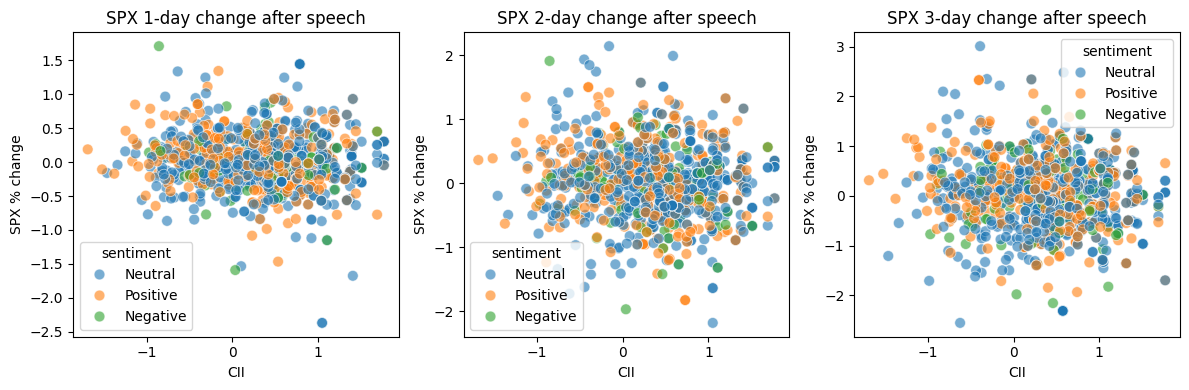

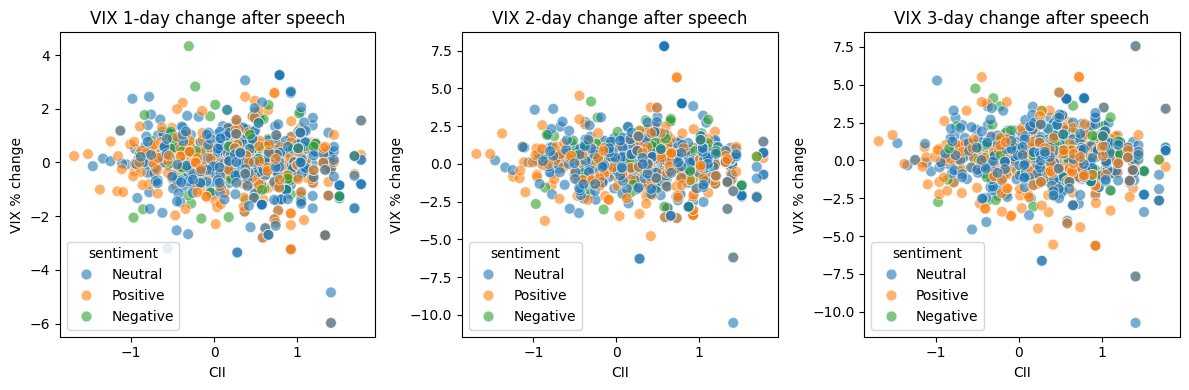

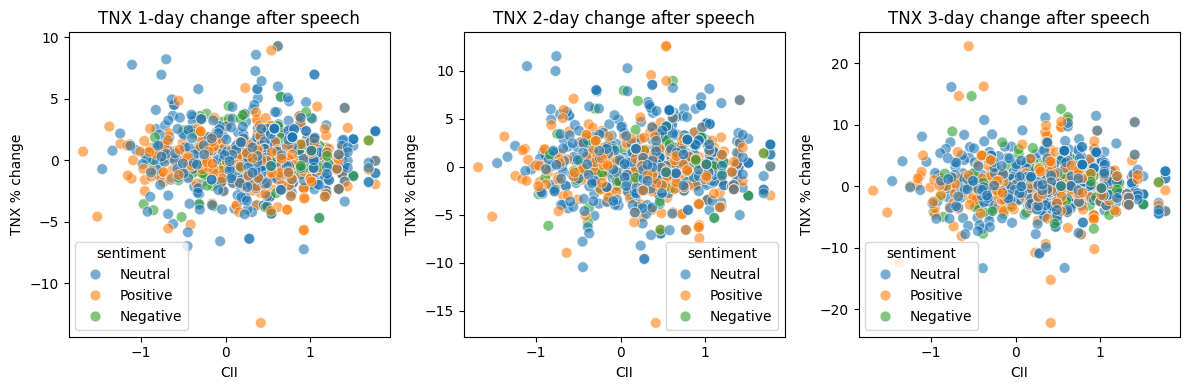

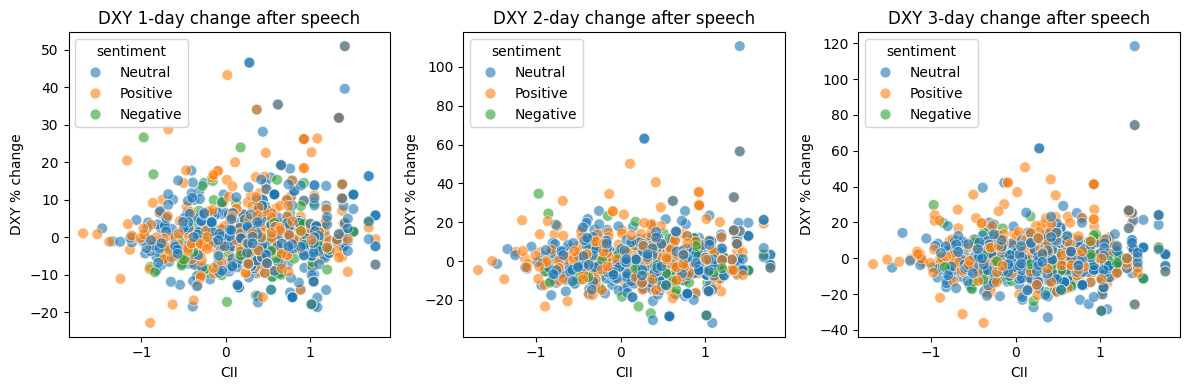

In [ ]:
market_vars = ["SPX", "VIX", "TNX", "DXY"]
horizons = [1, 2, 3]

for m in market_vars:
    plt.figure(figsize=(12, 4))
    for i, h in enumerate(horizons, 1):
        plt.subplot(1, 3, i)
        sns.scatterplot(
            x="CII",    
            hue="sentiment",          
            y=f"{m}_chg_{h}d",
            data=df_merge,
            s=60, alpha=0.6
        )
        plt.title(f"{m} {h}-day change after speech")
        plt.xlabel("CII")
        plt.ylabel(f"{m} % change")
        plt.legend(title="Sentiment", loc="best")
    plt.tight_layout()
    plt.show()

Next, we examine boxplots of market variations as a function of the CII. We observe that the variance tends to be slightly higher when the CII is elevated, but a statistical approach is required to quantify this effect. It is important to note that the CII was constructed as the sum of several normalized variables; however, weighting these variables according to their potential impact could provide a more accurate measure. In any case, we expect a substantial amount of noise, so while one might anticipate seeing the influence of the CII visually, it may be more reliably captured through statistical analysis rather than through plots alone. Here, we focus specifically on boxplots of VIX changes relative to the CII.

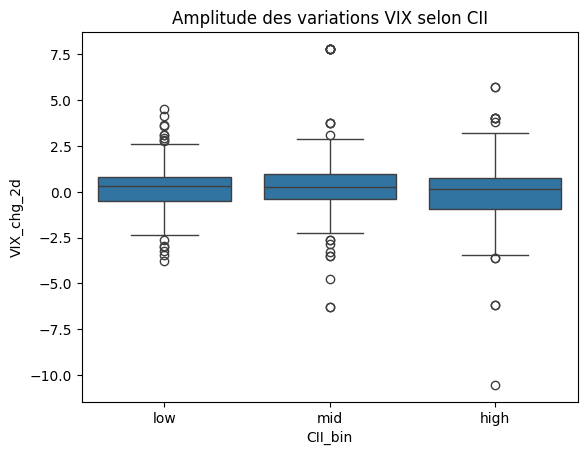

In [74]:
df_merge["CII_bin"] = pd.qcut(df_merge["CII"], q=3, labels=["low","mid","high"])

sns.boxplot(data=df_merge, x="CII_bin", y="VIX_chg_2d")
plt.title("Amplitude des variations VIX selon CII")
plt.show()

We next compute the correlations between the previously constructed CII and the market returns. To quantify the statistical significance of these correlations, we use the pearsonr function from the scipy.stats module, which provides both the correlation coefficient and its associated p-value. While the observed correlation values are generally low, most of them are statistically significant, indicating that despite the weak linear relationship, the CII does capture some measurable signal related to short-term market movements.

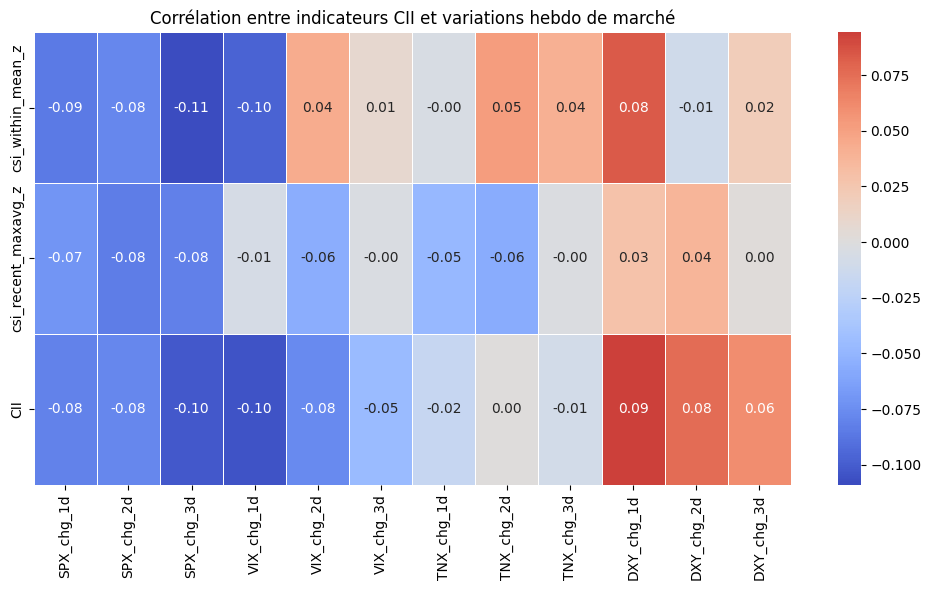

In [ ]:
features = ["csi_within_mean_z", "csi_recent_maxavg_z","CII"]

market_cols = ["SPX_chg_1d","SPX_chg_2d","SPX_chg_3d",
               "VIX_chg_1d","VIX_chg_2d","VIX_chg_3d"]

corr_matrix = df_merge[features + market_cols].corr().loc[features, market_cols]

# Plot Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0,fmt=".2f", linewidths=0.5)
plt.title("Corrélation entre indicateurs CII et variations hebdo de marché")
plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import pearsonr


results = []
for f in features:
    for m in market_cols:
        corr, pval = pearsonr(df_merge[f], df_merge[m])
        results.append([f, m, corr, pval])

df_corr = pd.DataFrame(results, columns=["Feature","Market","Corr","p_value"])
print(df_corr.sort_values("p_value"))

                Feature      Market      Corr   p_value
2     csi_within_mean_z  SPX_chg_3d -0.108902  0.000841
27                  CII  VIX_chg_1d -0.104806  0.001315
26                  CII  SPX_chg_3d -0.101994  0.001772
3     csi_within_mean_z  VIX_chg_1d -0.097351  0.002854
33                  CII  DXY_chg_1d  0.094217  0.003894
0     csi_within_mean_z  SPX_chg_1d -0.085276  0.009012
9     csi_within_mean_z  DXY_chg_1d  0.083630  0.010436
13  csi_recent_maxavg_z  SPX_chg_2d -0.082773  0.011254
14  csi_recent_maxavg_z  SPX_chg_3d -0.081868  0.012181
24                  CII  SPX_chg_1d -0.081078  0.013043
25                  CII  SPX_chg_2d -0.078250  0.016587
1     csi_within_mean_z  SPX_chg_2d -0.078081  0.016823
28                  CII  VIX_chg_2d -0.076936  0.018503
34                  CII  DXY_chg_2d  0.075654  0.020556
12  csi_recent_maxavg_z  SPX_chg_1d -0.071209  0.029288
35                  CII  DXY_chg_3d  0.060267  0.065181
19  csi_recent_maxavg_z  TNX_chg_2d -0.056143  0

In this analysis, we focus on the individual features that compose the Composite Indicator of Influence (CII) to determine appropriate weights for each component. To ensure robustness and avoid overfitting, the dataset is split into training and test sets. On the training set, we estimate linear regression coefficients for each feature and calculate their statistical significance through t‑tests and p‑values, providing insight into which speech-related characteristics meaningfully affect market movements. On the test set, we use the pre‑constructed, weighted CII to calculate its correlation with realized market changes, which allows us to evaluate how well the aggregated indicator reflects market behavior out-of-sample. For example, for the VIX 1-day change, the number of speeches shows a significant effect; after normalization, the coefficient is negative, but in terms of the original scale this corresponds to a positive influence on VIX, while the number of speakers also has a significant positive effect. Other features are not statistically significant. The correlation between the weighted CII and the actual VIX change on the test set is moderate (≈0.192), illustrating that this approach provides a coherent and statistically informed framework for allocating weights across features while maintaining predictive validity.

In [ ]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

features = ["n_speeches_z", "mean_wordcount_z", "n_speakers_z",
            "csi_within_mean_z", "csi_recent_maxavg_z", "tone_score"]

market_cols = ["SPX_chg_1d","SPX_chg_2d","SPX_chg_3d",
               "VIX_chg_1d","VIX_chg_2d","VIX_chg_3d",
               "TNX_chg_1d","TNX_chg_2d","TNX_chg_3d",
               "DXY_chg_1d","DXY_chg_2d","DXY_chg_3d"]


market_cols = ["VIX_chg_1d"]

# Split train/test

train, test = train_test_split(df_merge, test_size=0.3, shuffle=False)

results_dict = {}
for mkt in market_cols:
    X_train = sm.add_constant(train[features])
    y_train = train[mkt]

    # Régression OLS
    model = sm.OLS(y_train, X_train).fit()
    results_dict[mkt] = model

    print(f"=== {mkt} ===")
    print(model.summary())
    print("\n")

    # Weighted CII on the test set
    X_test = sm.add_constant(test[features])
    test[f"CII_weighted_{mkt}"] = model.predict(X_test)

    # Correlation weighted CII vs market on test set
    corr = test[f"CII_weighted_{mkt}"].corr(test[mkt])
    print(f"Corrélation pondéré CII vs {mkt} sur test set: {corr:.3f}\n")

=== VIX_chg_1d ===
                            OLS Regression Results                            
Dep. Variable:             VIX_chg_1d   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     3.604
Date:              mer., 12 nov. 2025   Prob (F-statistic):            0.00160
Time:                        15:31:12   Log-Likelihood:                -899.84
No. Observations:                 655   AIC:                             1814.
Df Residuals:                     648   BIC:                             1845.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const          

The analysis indicates that the most influential variables in explaining short-term VIX movements are the number of speeches and the number of speakers. Both show statistically significant effects, suggesting that the market reacts to the quantity of communication rather than its redundancy. In contrast, the CSI-related variables are not significant, implying that repeated or highly similar content does not trigger notable market responses. Overall, while the correlations remain relatively low, these findings highlight that certain features of speeches carry measurable information for market volatility.

A ajouter : meilleure interpretation (positif/négatif) et voir si on va plus loin dans la modélisation (lasso/ridge... ou d'avantage d'analyse du CSI)